### Importing libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#Seaborn
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


### Importing dataset

In [2]:
neighborhoods = pd.read_csv("Neighbourhoods.csv")

In [3]:
neighborhoods.head()

Neighborhood  Longitude   Latitude
0               Agincourt North (129) -79.266712  43.805441
1  Agincourt South-Malvern West (128) -79.265612  43.788658
2                      Alderwood (20) -79.541611  43.604937
3                          Annex (95) -79.404001  43.671585
4              Banbury-Don Mills (42) -79.349718  43.737657

In [4]:
# Getting the number of neighborhoods
print('The dataframe has {} neighborhoods.'.format(neighborhoods.shape[0]))

The dataframe has 140 neighborhoods.


Note: The numbers in the neighborhood column represent each neighborhood's ID. It's important to keep them to visualize the choropleth map later on since this is how the neighborhood names are stored in the geojson file

### Creating a map of Toronto with neighborhoods

In [5]:
#Obtaining the geographical coordinates of the City of Toronto

address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [6]:
from IPython.display import HTML, display

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

### Extracting the number of parks in each neighborhood

In [7]:
# Define Foursquare Credentials
CLIENT_ID = 'OA35LAYGTJPGETIF1QWUA0C5F3EKWOVY113415BLNE5ZLUKN' 
CLIENT_SECRET = 'QPOZUBTPRF0E2N24V05D3IOU1BS3RXIMGZAGILJVB0WERHR1' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OA35LAYGTJPGETIF1QWUA0C5F3EKWOVY113415BLNE5ZLUKN
CLIENT_SECRET:QPOZUBTPRF0E2N24V05D3IOU1BS3RXIMGZAGILJVB0WERHR1


In [8]:
# Obtain 100 venues in each neighborhood within a radius of 1000 meters

LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Create a new dataframe with extracted venues
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Agincourt North (129)
Agincourt South-Malvern West (128)
Alderwood (20)
Annex (95)
Banbury-Don Mills (42)
Bathurst Manor (34)
Bay Street Corridor (76)
Bayview Village (52)
Bayview Woods-Steeles (49)
Bedford Park-Nortown (39)
Beechborough-Greenbrook (112)
Bendale (127)
Birchcliffe-Cliffside (122)
Black Creek (24)
Blake-Jones (69)
Briar Hill-Belgravia (108)
Bridle Path-Sunnybrook-York Mills (41)
Broadview North (57)
Brookhaven-Amesbury (30)
Cabbagetown-South St.James Town (71)
Caledonia-Fairbank (109)
Casa Loma (96)
Centennial Scarborough (133)
Church-Yonge Corridor (75)
Clairlea-Birchmount (120)
Clanton Park (33)
Cliffcrest (123)
Corso Italia-Davenport (92)
Danforth (66)
Danforth East York (59)
Don Valley Village (47)
Dorset Park (126)
Dovercourt-Wallace Emerson-Junction (93)
Downsview-Roding-CFB (26)
Dufferin Grove (83)
East End-Danforth (62)
Edenbridge-Humber Valley (9)
Eglinton East (138)
Elms-Old Rexdale (5)
Englemount-Lawrence (32)
Eringate-Centennial-West Deane (11)
Etobicoke West

In [10]:
# Display toronto_venues data
print(toronto_venues.shape)
toronto_venues.head()

(5667, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Agincourt North (129)              43.805441              -79.266712   
1  Agincourt North (129)              43.805441              -79.266712   
2  Agincourt North (129)              43.805441              -79.266712   
3  Agincourt North (129)              43.805441              -79.266712   
4  Agincourt North (129)              43.805441              -79.266712   

                                      Venue  Venue Latitude  Venue Longitude  \
0                                 Menchie's       43.808338       -79.268288   
1  Saravanaa Bhavan South Indian Restaurant       43.810117       -79.269275   
2                        Shoppers Drug Mart       43.808894       -79.269854   
3                             Booster Juice       43.809915       -79.269382   
4          Samosa King - Embassy Restaurant       43.810152       -79.257316   

       Venue Category  
0  Frozen Yogurt Shop  
1   Indian Restaurant  
2            Pharmacy  
3           Juice Bar  
4   Indian Restaurant

In [11]:
# Filter venues to select parks
toronto_venues=toronto_venues.loc[toronto_venues['Venue Category'] =='Park']
print('Total number of parks within the selected radius is', toronto_venues.shape[0])

Total number of parks within the selected radius is 221


In [12]:
# Show the number of parks by neighborhoods
parks = toronto_venues.groupby('Neighborhood')['Venue'].count()
parks.head(10)

Neighborhood
Agincourt North (129)         1
Alderwood (20)                3
Annex (95)                    2
Banbury-Don Mills (42)        1
Bathurst Manor (34)           2
Bay Street Corridor (76)      3
Bayview Village (52)          3
Bayview Woods-Steeles (49)    3
Bedford Park-Nortown (39)     1
Bendale (127)                 3
Name: Venue, dtype: int64

### Merging the sustainability variables table with the neighborhood table

In [13]:
# Import the dataset with sustainability indicators
sustain = pd.read_csv("sustain.csv")
print(sustain.dtypes)
print(sustain.shape)

Neighborhood               object
Green Space (per 1000)    float64
Healthy Food Index        float64
Businesses (per 1000)       int64
Total Population            int64
dtype: object
(140, 5)


In [14]:
# Display the "sustainability" dataset
sustain=sustain.sort_values(by=['Neighborhood']).reset_index(drop=True)
sustain.head()

Neighborhood  Green Space (per 1000)  \
0               Agincourt North (129)                    8.59   
1  Agincourt South-Malvern West (128)                   10.09   
2                      Alderwood (20)                   24.26   
3                          Annex (95)                    3.69   
4              Banbury-Don Mills (42)                   46.19   

   Healthy Food Index  Businesses (per 1000)  Total Population  
0               38.09                     12             29113  
1               35.26                     58             23757  
2               11.41                     26             12054  
3               38.85                     76             30526  
4               21.31                     30             27695

In [15]:
# Prepare the "neighborhood" and "sustainability" datasets for concatination
neighborhoods=neighborhoods.sort_values(by=['Neighborhood']).reset_index(drop=True)

sustain.drop(['Neighborhood'], axis=1, inplace=True)
sustain.head()

Green Space (per 1000)  Healthy Food Index  Businesses (per 1000)  \
0                    8.59               38.09                     12   
1                   10.09               35.26                     58   
2                   24.26               11.41                     26   
3                    3.69               38.85                     76   
4                   46.19               21.31                     30   

   Total Population  
0             29113  
1             23757  
2             12054  
3             30526  
4             27695

In [16]:
# Concatinate the datasets
neighbors=pd.concat([neighborhoods, sustain], axis=1)
neighbors.head()

Neighborhood  Longitude   Latitude  \
0               Agincourt North (129) -79.266712  43.805441   
1  Agincourt South-Malvern West (128) -79.265612  43.788658   
2                      Alderwood (20) -79.541611  43.604937   
3                          Annex (95) -79.404001  43.671585   
4              Banbury-Don Mills (42) -79.349718  43.737657   

   Green Space (per 1000)  Healthy Food Index  Businesses (per 1000)  \
0                    8.59               38.09                     12   
1                   10.09               35.26                     58   
2                   24.26               11.41                     26   
3                    3.69               38.85                     76   
4                   46.19               21.31                     30   

   Total Population  
0             29113  
1             23757  
2             12054  
3             30526  
4             27695

In [17]:
# Datatypes of new dataset
neighbors.dtypes

Neighborhood               object
Longitude                 float64
Latitude                  float64
Green Space (per 1000)    float64
Healthy Food Index        float64
Businesses (per 1000)       int64
Total Population            int64
dtype: object

### Building the K-means models

In [18]:
#Drop columns not used in the model and scale remaning columns
neighbors_cl = neighbors.drop(['Neighborhood','Longitude','Latitude','Total Population'], axis = 1)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
neighbors_sc = sc.fit_transform(neighbors_cl)

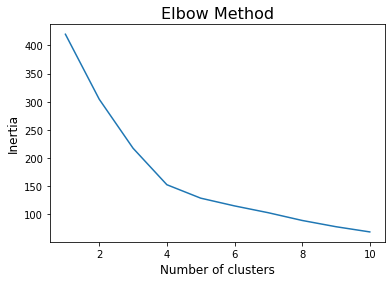

In [19]:
# Use the "elbow method" to choose an optimum number of clusters for K-means

wcss=[]
for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=0)
    model.fit(neighbors_sc)
    wcss.append(model.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('Elbow Method', fontsize=16)
plt.ylabel('Inertia', fontsize=12)
plt.xlabel('Number of clusters', fontsize=12)
plt.savefig("Elbow.png")

In [20]:
# Run the model with 5 clusters as per the "elbow method"

n_clusters=5

model = KMeans(n_clusters)
model.fit(neighbors_sc)
model.cluster_centers_
model.inertia_
cluster_assignments=model.predict(neighbors_sc)

In [21]:
# Cluster centers
model.cluster_centers_

array([[-0.2247837 ,  0.05214791, -0.26793099],
       [ 5.06099719, -1.34913607, -0.57381703],
       [ 0.31031597, -1.28334659, -0.40760263],
       [-0.27029661,  1.15586045, -0.05936378],
       [-0.25494508,  0.06357282,  2.67541684]])

In [22]:
# Add the cluster labels to the "neighbors" dataset
neighbors.insert(1, 'Cluster Labels', model.labels_)

neighbors.head()

Neighborhood  Cluster Labels  Longitude   Latitude  \
0               Agincourt North (129)               0 -79.266712  43.805441   
1  Agincourt South-Malvern West (128)               4 -79.265612  43.788658   
2                      Alderwood (20)               2 -79.541611  43.604937   
3                          Annex (95)               4 -79.404001  43.671585   
4              Banbury-Don Mills (42)               2 -79.349718  43.737657   

   Green Space (per 1000)  Healthy Food Index  Businesses (per 1000)  \
0                    8.59               38.09                     12   
1                   10.09               35.26                     58   
2                   24.26               11.41                     26   
3                    3.69               38.85                     76   
4                   46.19               21.31                     30   

   Total Population  
0             29113  
1             23757  
2             12054  
3             30526  
4             27695

### Analysis of the clusters

In [23]:
# Display the number of neighborhoods for each cluster
value_counts = neighbors['Cluster Labels'].value_counts()
cluster_count = pd.DataFrame(value_counts).reset_index()
cluster_count.columns = ['Clusters', 'Number of Neighborhoods']
cluster_count

Clusters  Number of Neighborhoods
0         0                       55
1         3                       37
2         2                       33
3         4                       12
4         1                        3

In [24]:
# Summary of "neighbors"
neighbors.describe()

Cluster Labels   Longitude    Latitude  Green Space (per 1000)  \
count      140.000000  140.000000  140.000000              140.000000   
mean         1.628571  -79.400186   43.708841               27.966286   
std          1.441137    0.102044    0.051274               37.385386   
min          0.000000  -79.596356   43.592362                0.190000   
25%          0.000000  -79.479794   43.671009                7.012500   
50%          2.000000  -79.403989   43.702021               15.875000   
75%          3.000000  -79.331097   43.747294               32.315000   
max          4.000000  -79.150843   43.821201              306.940000   

       Healthy Food Index  Businesses (per 1000)  Total Population  
count          140.000000             140.000000        140.000000  
mean            32.226357              25.828571      19511.221429  
std             10.423960              23.602811      10033.589222  
min              0.630000               3.000000       6577.000000  
25%             24.837500              12.000000      12019.500000  
50%             32.695000              19.000000      16749.500000  
75%             40.302500              30.000000      23854.500000  
max             53.480000             168.000000      65913.000000

### 1. Green Space

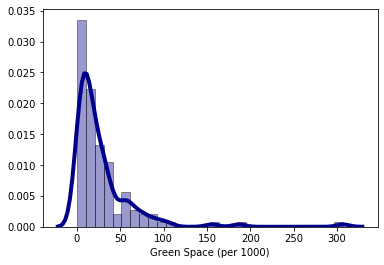

In [25]:
# Green Space (Density Curve)
sns.distplot(neighbors['Green Space (per 1000)'], hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [26]:
# Identifying outliers and discretization
gs = neighbors["Green Space (per 1000)"].to_numpy()
upper_quartile = np.percentile(gs, 75)
lower_quartile = np.percentile(gs, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = gs[gs<=upper_quartile+3*iqr].max()
lower_whisker = gs[gs>=lower_quartile-3*iqr].min()

print("Max:", upper_whisker)
print("Min:", lower_whisker)
interval = ((upper_whisker-lower_whisker)/3)
print("Low:", lower_whisker,"-", lower_whisker+interval)
print("Medium:",lower_whisker+interval,"-", lower_whisker+interval*2)
print("High:",lower_whisker+interval*2,"-", upper_whisker)
print("Very High:",upper_whisker,"<")

Max: 106.23
Min: 0.19
Low: 0.19 - 35.53666666666667
Medium: 35.53666666666667 - 70.88333333333334
High: 70.88333333333334 - 106.23
Very High: 106.23 <


In [27]:
# Summary of discretized levels by clusters
neighbors['Green Space (per 1000)']=pd.cut(neighbors['Green Space (per 1000)'], 
                                           bins=[0, 36, 71, 107, 307], 
                                           labels=['Low','Med','High','Very High'],
                                           include_lowest=True)

neighbors.groupby(['Cluster Labels','Green Space (per 1000)'])['Green Space (per 1000)'].count()

Cluster Labels  Green Space (per 1000)
0               Low                       47
                Med                        8
1               Very High                  3
2               Low                       19
                Med                        9
                High                       5
3               Low                       33
                Med                        1
                High                       3
4               Low                       10
                Med                        2
Name: Green Space (per 1000), dtype: int64

### 2. Healthy Food Index

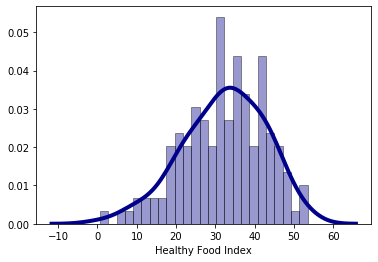

In [28]:
# Healthy Food Index
sns.distplot(neighbors['Healthy Food Index'], hist=True, kde=True, 
             bins=25, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [29]:
# Identifying outliers and discretization
hfi = neighbors["Healthy Food Index"].to_numpy()
upper_quartile = np.percentile(hfi, 75)
lower_quartile = np.percentile(hfi, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = hfi[hfi<=upper_quartile+3*iqr].max()
lower_whisker = hfi[hfi>=lower_quartile-3*iqr].min()

print("Max:", upper_whisker)
print("Min:", lower_whisker)
interval = ((upper_whisker-lower_whisker)/3)
print("Low:", lower_whisker,"-", lower_whisker+interval)
print("Medium:",lower_whisker+interval,"-", lower_whisker+interval*2)
print("High:",lower_whisker+interval*2,"-", upper_whisker)
print("Very low: <",lower_whisker)

Max: 53.48
Min: 0.63
Low: 0.63 - 18.246666666666663
Medium: 18.246666666666663 - 35.86333333333333
High: 35.86333333333333 - 53.48
Very low: < 0.63


In [30]:
# Summary of discretized levels by clusters
neighbors['Healthy Food Index']=pd.cut(neighbors['Healthy Food Index'], 
                                           bins=[0, 19, 36, 54], 
                                           labels=['Low','Med','High'],
                                           include_lowest=True)

neighbors.groupby(['Cluster Labels','Healthy Food Index'])['Healthy Food Index'].count()

Cluster Labels  Healthy Food Index
0               Med                   46
                High                   9
1               Low                    1
                Med                    2
2               Low                   14
                Med                   19
3               High                  37
4               Med                    8
                High                   4
Name: Healthy Food Index, dtype: int64

### 3. Businesses

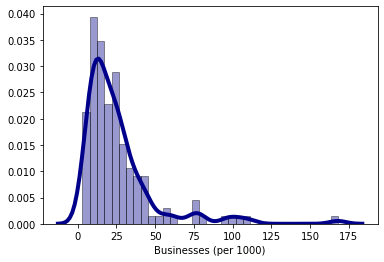

In [31]:
# Businesses
sns.distplot(neighbors['Businesses (per 1000)'], hist=True, kde=True, 
             bins=35, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [32]:
# Identifying outliers and discretization
bs = neighbors["Businesses (per 1000)"].to_numpy()
upper_quartile = np.percentile(bs, 75)
lower_quartile = np.percentile(bs, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = bs[bs<=upper_quartile+3*iqr].max()
lower_whisker = bs[bs>=lower_quartile-3*iqr].min()

print("Max:", upper_whisker)
print("Min:", lower_whisker)
interval = ((upper_whisker-lower_whisker)/3)
print("Low:", lower_whisker,"-", lower_whisker+interval)
print("Medium:",lower_whisker+interval,"-", lower_whisker+interval*2)
print("High:",lower_whisker+interval*2,"-", upper_whisker)
print("Very High:",upper_whisker,"<")

Max: 79
Min: 3
Low: 3 - 28.333333333333332
Medium: 28.333333333333332 - 53.666666666666664
High: 53.666666666666664 - 79
Very High: 79 <


In [33]:
# Summary of discretized levels by clusters
neighbors['Businesses (per 1000)']=pd.cut(neighbors['Businesses (per 1000)'], 
                                           bins=[0, 29, 54, 79, 168], 
                                           labels=['Low','Med','High','Very High'],
                                           include_lowest=True)

neighbors.groupby(['Cluster Labels','Businesses (per 1000)'])['Businesses (per 1000)'].count()

Cluster Labels  Businesses (per 1000)
0               Low                      46
                Med                       9
1               Low                       3
2               Low                      28
                Med                       5
3               Low                      25
                Med                      12
4               High                      7
                Very High                 5
Name: Businesses (per 1000), dtype: int64

### Superimposing clusters on the population choropleth map

In [34]:
# Check how "neighbors" looks now
neighbors.head()

Neighborhood  Cluster Labels  Longitude   Latitude  \
0               Agincourt North (129)               0 -79.266712  43.805441   
1  Agincourt South-Malvern West (128)               4 -79.265612  43.788658   
2                      Alderwood (20)               2 -79.541611  43.604937   
3                          Annex (95)               4 -79.404001  43.671585   
4              Banbury-Don Mills (42)               2 -79.349718  43.737657   

  Green Space (per 1000) Healthy Food Index Businesses (per 1000)  \
0                    Low               High                   Low   
1                    Low                Med                  High   
2                    Low                Low                   Low   
3                    Low               High                  High   
4                    Med                Med                   Med   

   Total Population  
0             29113  
1             23757  
2             12054  
3             30526  
4             27695

In [35]:
# download the neighborhoods geojson file to display neighborhood boundaries
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/labs/DP0701EN/Neighbourhoods.geojson -O Neighbourhoods.geojson
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [36]:
# Choropleth map of neighborhoods' population
toronto_geo = r'Neighbourhoods.geojson' # geojson file

# generating choropleth map 
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=11)

toronto_map.choropleth(
    geo_data=toronto_geo,
    data=neighbors,
    columns=['Neighborhood','Total Population'],
    key_on='feature.properties.AREA_NAME',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population by Neighborhoods'
)

# display the map
toronto_map

In [37]:
# Display clusters on top of the population choropleth map

# setting color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbors['Latitude'], neighbors['Longitude'], neighbors['Neighborhood'], neighbors['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map)
       
toronto_map.save("clusters.html")

toronto_map